In [8]:
# Experiments
ABC={}
ABC[2] = 1
print(ABC)

{2: 1}


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from   datetime import datetime
from   sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.utils.data import DataLoader, TensorDataset
import ot
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

In [10]:
run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir    = f"run_{run_timestamp}"

try:
    os.makedirs(output_dir, exist_ok=True)
    print(f"Created output directory: {output_dir}")    
except Exception as e:
    print(f"Error creating output directory {output_dir}: {e}") 

Created output directory: run_20251106_122158


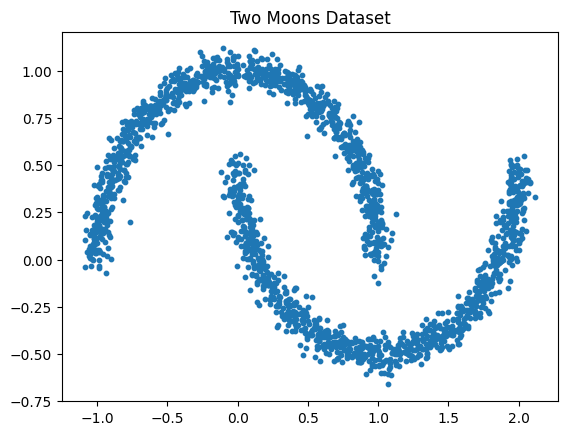

In [11]:
def cleanup_files(patterns):
    for pattern in patterns:
        for file_path in glob.glob(pattern):
            try:
                os.remove(file_path)
                #print(f"Deleted file: {file_path}")
            except Exception as e:
                print(f"Error deleting file {file_path}: {e}")

# Clean up old generated files
cleanup_files(["generated_data_t*.png", "two_moons_hist_*.png", "training_loss_*.png", "real_vs_generated_scatter_*.png"])

# 1. GENERATE 2D two-moons data

#2000 rows
n_samples = 2000 ##S5
# X is the array/tensor that holds all the 2d coords of datapoints
#array of shape (2000,2), each row is a point (x,y)
#add a small amount of noise to make the moons less perfectly shaped
X, _ = make_moons(n_samples=n_samples, noise=0.05)
# convert the numpy array to pytorchtensor
X = torch.tensor(X, dtype=torch.float32)

#make a scatter plot of the two moons dataset, x-coords first col
#y-coords second col. Point size is 10
plt.scatter(X[:,0], X[:,1], s=10)
plt.title("Two Moons Dataset")
#plt.show()

# 2. DEFINE DIFFUSION SCHEDULE

# this is the total number of times we will add a tiny bit of noise (scalar int)
T = 1000  # number of diffusion steps
# Beta creates a 1d tensor of length T (200) with values linearly spaced from 0.0001 to 0.02
# Each value represents the variance of the noise added at each diffusion step
# Smaller values at the start, larger at the end;larger noise as we progress through diffusion steps
#beta = torch.linspace(1e-4, 0.02, T)  # noise schedule  ##1


def cosine_beta_schedule(T, s=0.008): ##S1
    """
    cosine schedule  from https://arxiv.org/abs/2102.09672

    args:
        T (int): Total number of timesteps
        s (float): Small offset to prevent beta from being too small near t=0

    returns:
        torch.Tensor: Beta schedule of shape (T,)
    """
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999).float() ##S2


beta = cosine_beta_schedule(T)  # shape: (200,)
##SS15: This is under question!

# Alpha is 1 minus beta, representing the portion of the original data retained at each step
# it controls how much of the previous signal you keep at each step.
# it is also a (200,) tensor
alpha = 1 - beta
# alpha_bar is the cumulative product of alpha, representing the total portion of original data retained up to each step
#This is the key schedule used in DDPMs: it tells you, in closed form, how much of the original clean sample x₀ remains after t noising steps.
#Shape: (200,).
alpha_bar = torch.cumprod(alpha, dim=0)  # cumulative product


# 3. DEFINE SIMPLE DENOISING MODEL

# a simple PyTorch neural network
class DenoiseMLP(nn.Module):
    def __init__(self):
        #call the parent constructor
        super().__init__()
        #first layer takes in 2d coords + 1 time embedding
        # and it outputs 128 features
        #weight shape: (128,3), bias shape: (128,)
        self.fc1 = nn.Linear(2+1, 128)  # +1 for time embedding
        #hidden, second linear layer
        # takes in 128 features, outputs 128 features
        #weight shape: (128,128), bias shape: (128,)
        self.fc2 = nn.Linear(128, 128)
        #final layer takes in 128 features, outputs 2d coords (the predicted noise)
        self.fc3 = nn.Linear(128, 2)
    

    # Assume a batch size of N
    # x should be: (N, 2) - noised data at time t. each row is a 2d point
    # t should be: (N,) - time steps for each sample in the batch (N,1) is 1 timestep per sample
    def forward(self, x, t):
        # Normalize t
        #normalize t to be between 0 and 1 roughly, since T=200
        t = t / T
        # Add time embedding
        #unsqueeze adds a new dimension at the end, so t_embed is (N,1) if t was (N,)
        t_embed = t.unsqueeze(-1)
        # Concatenate x and t_embed along the feature dimension
        #cat along dim=1 (the feature dimension), so h is (N,3) (2 features from x, +1 from time embed)
        h = torch.cat([x, t_embed], dim=1)
        # Linear transform fc1: (N,3) * (3,128)^T + bias → (N,128).
        #F.relu applies ReLU nonlinearity elementwise, keeping shape (N,128)
        h = F.relu(self.fc1(h))
        # another Linear transform fc2: (N,128) *
        #  (128,128)^T + bias → (N,128).
        h = F.relu(self.fc2(h))
        # Final linear layer fc3: (N,128) @ (128,2)^T + bias → (N,2).
        #Returned tensor has shape (N, 2). Interpretation: a two-component vector per input point (e.g., predicted noise )
        return self.fc3(h)

# Instantiate model and optimizer
model = DenoiseMLP()
#Adam optimizer will update all model.parameters() with learning rate 1e-3.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) ##S3


epoch_losses = []
# 4. TRAINING LOOP

# epochs: total number of times the entire dataset is passed through the model
n_epochs = 2000
# batch size = number of samples processed in one forward/backward pass (before the models paramters are updated during training)
# a sample is a single data point (2d coord here)
#batch_size = 128
batch_size = 2000 ##S4
dataset = TensorDataset(X) ##S6
# samples are mixed up each epoch
dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True) ##S7

In [12]:
#loop over the epochs, aka repeat trainig process 2000 times
for epoch in range(n_epochs):
    # Sample random batch of data
    #
    # idx = torch.randint(0, n_samples, (batch_size,))
    # x0 is the clean data for this batch, shape (batch_size, 2) - 128 points each with 2 features (x,y)
    #essentially: a tesnor of shape (128, 2)
    #x0 = X[idx]

    batch_losses = [] ##SS12: You're overwriting this!
    
    for batch_x0 in dataLoader:
        x0 = batch_x0[0]
        current_batch_size = x0.shape[0]
        # Sample random timestep
        # sample a random timestep for each point/sample in the batch
        t = torch.randint(0, T, (current_batch_size,)).to(x0.device)  # (batch_size,)
        ##S8: Contains the last point?

        # Forward diffusion q(x_t | x_0)

        # this makes random gaussian noise with the same shape as x0, so (128,2)
        # each row is noise sampled from a normal distribution
        #this is the true noise that the model will try to predict later
        noise = torch.randn_like(x0)
        # alpha_bar is precomputed (200,) tensor - one value per timestep
        #t is (128,), so alpha_bar[t] is (128,) - one value per sample in the batch
        #it picks the value for each sample's timestep t
        #unsqueeze(-1) makes it (128,1) so we can broadcast in the next step
        alpha_bar_t = alpha_bar[t].unsqueeze(-1)
        # THIS IS THE FORWARD DIFFUSION EQUATION
        # x_t is the noised version of x0 at timestep t
        # At small t, noise is small, at large t, noise is larg
        x_t = torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*noise ##S9: Are dimesions right for dot multip instead of matrix multip?!
        
        ##SS13: The same 2000 source points, in new order, are added with different noise level (t) each time, that's the only thing that is changing.
        
        # Predict noise
        # feed the noised sample x_t and its timestep t
        # model tries to guess the exact noise that was added to x0 to get x_t
        # x_t is (128,2), t.float() is (128,) - one
        #noise_pred is (128,2) - the model's predicted noise for each sample
        noise_pred = model(x_t, t.float())
        
        # Compute loss (MSE between true noise and predicted noise
        # the closer loss is to 0, the better the model is at predicting the noise added at each step
        # loss is a scalar tensor
        loss = F.mse_loss(noise_pred, noise)

        #stopped here again
        # clears old gradients
        optimizer.zero_grad()
        #computes newe gradients of loss with respect to all the weights using backprop
        loss.backward()
        # updates weights with gradient descent (adam is a gradient descent? variant)
        optimizer.step()
        batch_losses.append(loss.item())
        ##S10: You're not doing SGD, you're doing GD!

    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_epoch_loss)


    # Print loss every 200 epochs
    #loss.item() gets the raw float value of the loss tensor and converts to python float for easier printing
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

Epoch 0, Loss 1.0147
Epoch 200, Loss 0.3843
Epoch 400, Loss 0.3391
Epoch 600, Loss 0.3645
Epoch 800, Loss 0.3353
Epoch 1000, Loss 0.3346
Epoch 1200, Loss 0.3249
Epoch 1400, Loss 0.3450
Epoch 1600, Loss 0.3202
Epoch 1800, Loss 0.3499


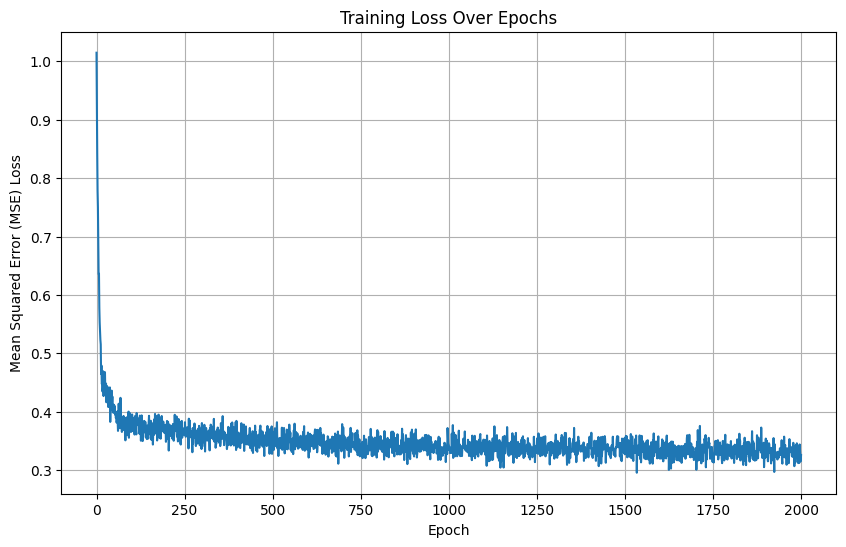

In [13]:
"""
        for t_visualize in [0, 50, 100,199]:

            alpha_bar_t = alpha_bar[t_visualize]
            x_t_visualize = torch.sqrt(alpha_bar_t)*X + torch.sqrt(1-alpha_bar_t)*torch.randn_like(X)
            plt.scatter(x_t_visualize[:,0], x_t_visualize[:,1], s=2)
            plt.title(f"Noised Data at Timestep {t_visualize} (epoch {epoch})")
            plt.savefig(f"noised_data_epoch{epoch}_t{t_visualize}.png", dpi=300)
            plt.close()
"""


plt.figure(figsize=(10, 6))
# Plot the list of average epoch losses
plt.plot(range(n_epochs), epoch_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.grid(True)
# Save the plot with a timestamp

plt.savefig(os.path.join(output_dir, "training_loss.png"), dpi=300)

In [ ]:
# 5. SAMPLING FROM LEARNED MODEL


# time to generate new data after training
# tell pytorch not to track gradients, cause we don't need the gradient history since
# we are not training anymore

# define a function that samples n_samples 
# start from pure gaussian noise
# shape is (n_samples, 2) since our data is 2d two-moons
@torch.no_grad()
def sample(model, n_samples):
    x = torch.randn(n_samples, 2)  # start from pure noise
    # collect snapshots for selected timesteps and plot them later as a grid
    snapshots = {} ##SS20: This is purely/only for T=1000!
    snapshot_timesteps = [999, 750, 500, 300, 199, 150, 100, 50, 40, 30, 20, 15, 10, 5, 0]
    #loop over timesteps in reverse order
    for t in reversed(range(T)):
        # Create a 1-D tesnor of length n_samples, where all entries == current timestep t
        # this is needed because the model expects a batch of timesteps, one per sample
        #the shape is (n_samples, )
        t_batch = torch.full((n_samples,), t, dtype=torch.float32)
        # calls the denoiser model to predict the noise in x at timestep t
        # x is (n_samples, 2), t_batch is (n_samples,)
        predicted_noise = model(x, t_batch)
        #the following 3 lines index the precomputed schedules to get the scalar values for the current timestep t
        # alpha_t represents the portion of the original data retained at step t
        alpha_t = alpha[t]
        # alpha_bar_t represents the total portion of original data retained up to step t (cumulative product)
        alpha_bar_t = alpha_bar[t]
        # beta_t represents the variance of the noise added at step t
        beta_t = beta[t]
        
        # Reverse diffusion step IMPORTANT
        # this equation is the algebraic reverse step that tries to recover x_{t-1} from x_t - computes the posterior mean estimate
        # It uses the model's predicted noise to subtract out the noise component from x
        #first multiplies x by 1/sqrt(alpha_t) to scale it up to undo the forward step shrink
        x = 1/torch.sqrt(alpha_t) * (x - (1-alpha_t)/torch.sqrt(1-alpha_bar_t)*predicted_noise)
        # Add noise except for the last step (last step t=0 should be clean)
        # torch.randn_like(x) makes gaussian noise of shape (n_samples, 2)
        # scaled by sqrt(beta_t) to control the amount of noise added back in 
        # (we want to add a small amount of noise back in at each step to maintain stochasticity so outputs are diverse) 
        #   REVERSE PROCESS IS STOCHASTIC, NOT DETERMINISTIC
        if t > 0:
            x += torch.sqrt(beta_t) * torch.randn_like(x) ###

        if t in snapshot_timesteps:
            # store a CPU copy of the current samples for later plotting
            snapshots[int(t)] = x.clone().detach().cpu()

     
    
    # put collected snapshots into a single grid figure
    if len(snapshots) > 0:
        # preserve the original ordering from snapshot_timesteps
        times = [t for t in snapshot_timesteps if t in snapshots]
        n = len(times)
        ncols = int(np.ceil(np.sqrt(n)))
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
        # flatten axes to a list for easy indexing
        if isinstance(axes, np.ndarray):
            axes_list = axes.ravel()
        else:
            axes_list = [axes]

        for idx, t in enumerate(times):
            ax = axes_list[idx]
            x_t = snapshots[t]
            h = ax.hist2d(x_t[:, 0].numpy(), x_t[:, 1].numpy(), bins=100, density=True, cmap='viridis')
            ax.set_title(f'Timestep {t}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')

        # turn off any extra axes
        for ax in axes_list[n:]:
            ax.axis('off')

        out_name = os.path.join(output_dir, f"generated_data_snapshots_{run_timestamp}.png")
        plt.tight_layout()
        plt.savefig(out_name, dpi=300)
        plt.close(fig)

    # finally, return the generated samples after all timesteps
    # x should now be a (n_samples, 2) tensor of generated 2d points that look like the two-moons data even though they started as pure noise
    return x


# # Generate samples
samples = sample(model, 200000)

# # 6. Print one random sample

print("One sample from generated data:", samples[torch.randint(0, samples.shape[0], (1,))])

#Wasserstein distance between real and generated data

print("Calculating Wassersteind distance between real and generated data")


n_real_samples =X.shape[0]
n_projections = 100
indices = torch.randperm(samples.shape[0])[:n_real_samples ]
samples_subset = samples[indices]

print(f"comparing {n_real_samples} real samples to {samples_subset.shape[0]} generated samples")

W_distance = ot.sliced_wasserstein_distance(X.numpy(), samples_subset.numpy(),n_projections=n_projections)
print(f"Sliced Wasserstein Distance (100 projections): {W_distance}")


plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], '.', markersize=2, label='Real Two-Moons Data')
plt.plot(samples_subset[:,0], samples_subset[:,1], '.', markersize=2, label='Generated Data')

plt.legend(loc=0)
plt.title(f"Real vs. Generated Samples (SWD: {W_distance:.6f})")

# Save the figure

plt.savefig(os.path.join(output_dir,"real_vs_generated_scatter_.png"), dpi=300)


# working on KL and JS divergence now
# convert tensors to numpy arrays
X_np = X.cpu().numpy()
samples_subset_np = samples_subset.cpu().numpy()
n_bins = 50

x_min = min(X_np[:,0].min(), samples_subset_np[:,0].min()) - 0.1
x_max = max(X_np[:,0].max(), samples_subset_np[:,0].max()) + 0.1
y_min = min(X_np[:,1].min(), samples_subset_np[:,1].min()) - 0.1
y_max = max(X_np[:,1].max(), samples_subset_np[:,1].max()) + 0.1
hist_range = [[x_min, x_max], [y_min, y_max]]

real_hist_counts, _, _ = np.histogram2d(X_np[:,0], X_np[:,1], bins=n_bins, range=hist_range)

fake_hist_counts, _, _ = np.histogram2d(samples_subset_np[:,0], samples_subset_np[:,1], bins=n_bins, range=hist_range)

# Normalize histograms to get probability distributions
real_hist_probs = real_hist_counts / real_hist_counts.sum()
fake_hist_probs = fake_hist_counts / fake_hist_counts.sum()

P = real_hist_probs.flatten() + 1e-10  # add small constant to avoid log(0) ##SS22: Not sure about adding this constant
Q = fake_hist_probs.flatten() + 1e-10  # add small constant to avoid log(0)

kl_div  = entropy(P, Q)
kl_div2 = entropy(Q, P)
#calculate entropy P, Q
js_div  = jensenshannon(P, Q, base=2)**2  # square to get JS divergence

print(f"--- KL Divergence: {kl_div :.6f} ---")
print(f"--- KL Divergence: {kl_div2:.6f} ---")
print(f"--- JS Divergence: {js_div :.6f} ---")
print("(For KL and JS, 0 is a perfect match between real and generated distributions)")

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)

plt.imshow(real_hist_probs.T, origin='lower', extent=(x_min, x_max, y_min, y_max), aspect='auto', cmap='viridis')
plt.colorbar(label='Probability Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real Data Histogram')

plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd plot)

plt.imshow(fake_hist_probs.T, 
           origin='lower', 
           aspect='auto',
           extent=[x_min, x_max, y_min, y_max],
           cmap='viridis')

plt.colorbar(label='Probability Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data Distribution (Q)')

# Save the combined figure

plt.savefig(os.path.join(output_dir,"kl_js_histograms.png"), dpi=300)


metrics = ['KL Divergence', 'JS Divergence']
# The values you calculated
values = [kl_div, js_div]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['salmon', 'lightgreen'])

# add the value label on top of each bar
plt.bar_label(bars, fmt='%.4f')

plt.title('Final Model Evaluation Metrics')
plt.ylabel('Score (Lower is Better)')
# Give some space at the top
plt.ylim(0, max(values) * 1.2) 

# save the figure

plt.savefig(os.path.join(output_dir,"final_metrics_barchart.png"), dpi=300)


# 7. 2D histogram



plt.figure(figsize=(8,6))
plt.hist2d(samples[:,0].numpy(), samples[:,1].numpy(), bins=100, density=True, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Histogram of Generated Samples')
plt.savefig(os.path.join(output_dir,"two_moons_hist.png"), dpi=300)
plt.close()

In [ ]:
# function to track a sigle trajectory through the diffusion process

@torch.no_grad()
def generate_single_trajectory(model, start_noise, T):
    model.eval()
    x = start_noise.clone()
    trajectory = [x.clone().detach().cpu()] # store the starting point


    for t in reversed(range(T)):
        t_batch = torch.full((1,), t, dtype=torch.float32)
        predicted_noise = model(x, t_batch)
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]
        mu_tilde = 1 / torch.sqrt(alpha_t) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise)
        if t > 0:
            z = torch.randn_like(x)
            x = mu_tilde + torch.sqrt(beta_t) * z
        else:
            x = mu_tilde
        trajectory.append(x.clone().detach().cpu())
    
    return torch.cat(trajectory, dim=0)  # shape (T+1, 2)



# Stage for stochastic trajectory plot

n_runs = 5

#defining a starting noise vector to reuse for all 6 runs
# shape is (1,2) for a single 2d point

start_noise_vector = torch.rand(1,2) ##SS24: Why rand? **

#run the experiement
all_trajectories = []
for _ in range(n_runs):
    trajectory = generate_single_trajectory(model, start_noise_vector, T)
    all_trajectories.append(trajectory)

# plot the trajectories

fig, axes = plt.subplots(1,n_runs, figsize=(20,4),sharex=True, sharey=True)
fig.suptitle("Experiment: Stochasticity in Reverse Diffusion Trajectories from a Single Start", fontsize=16)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
plot_range = [[x_min, x_max], [y_min, y_max]]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i in range(n_runs):
    ax = axes[i]
    numpy_trajectory = all_trajectories[i].numpy()

    #plot the background real data
    ax.hist2d(
        X[:, 0].numpy(), 
        X[:, 1].numpy(), 
        bins=100, 
        cmap='Greys', 
        density=True, 
        alpha=0.6,
        range=plot_range
    )

    # Plot the trajectory path
    ax.plot(
        numpy_trajectory[:, 0], 
        numpy_trajectory[:, 1], 
        color=colors[i], 
        lw=1
    )

    #plot start and end points
    ax.plot(
        numpy_trajectory[0, 0], numpy_trajectory[0, 1], 
        'o', color='black', markersize=4, label='Start (Noise)'
    ) # Start
    ax.plot(
        numpy_trajectory[-1, 0], numpy_trajectory[-1, 1], 
        'x', color=colors[i], markersize=6, mew=2, label='End (Generated)'
    ) # End

    ax.set_title(f"Run {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Save the final plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.savefig(os.path.join(output_dir, "stochastic_trajectories.png"), dpi=300)
plt.close(fig)